<a href="https://colab.research.google.com/github/Suraj-Sedai/neural-signal-decoder/blob/main/notebook/testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Neural Signal Decoder (Simulated)

The Neural Signal Decoder (Simulated) project is a complete, end‑to‑end implementation of a neural time‑series decoding system inspired by Brain–Computer Interface (BCI) research. The system is designed to translate multichannel EEG‑like signals into discrete control actions using deep learning sequence models.

##System Architecture

The Neural Signal Decoder follows a modular pipeline architecture:


```NEURAL SIGNAL → PREPROCESSING → TEMPORAL ENCODER → CLASSIFIER → ACTION OUTPUT```


##ECE Signal

### Explanation of `simulate_eeg_sample` Function

This Python code defines a function `simulate_eeg_sample` which generates a simulated EEG-like signal based on a given `class_id`. It's designed to mimic neural signals with different frequency characteristics depending on the intended 'action' (represented by `class_id`).

#### Function Parameters:

*   **`class_id`**: An integer representing the 'action' or mental state (0, 1, 2, or 3). Each class is associated with a distinct frequency band.
*   **`num_channels`**: The number of simulated EEG channels.
*   **`num_timesteps`**: The number of data points (samples) in the time series for each channel.
*   **`sampling_rate`**: The number of samples per second (default is 256 Hz, common in EEG).

#### How the Signal is Generated (Mathematical Explanation):

1.  **Time Axis (`t`)**:

    ```python
    t = np.arange(num_timesteps) / sampling_rate
    ```

    *   `np.arange(num_timesteps)` creates an array of integers from `0` to `num_timesteps - 1`. These represent the sample indices.
    *   Dividing by `sampling_rate` converts these sample indices into actual time values in seconds. For example, if `sampling_rate` is 256, the first sample is at `t=0`, the second at `t=1/256`, the third at `t=2/256`, and so on.

2.  **Class-Dependent Frequency Bands (`FREQ_BANDS`)**:

    ```python
    FREQ_BANDS = {
        0: (8, 12),    # Alpha
        1: (13, 30),   # Beta
        2: (4, 7),     # Theta
        3: (30, 45),   # Gamma
    }
    low_f, high_f = FREQ_BANDS[class_id]
    ```

    This dictionary maps each `class_id` to a specific frequency range (`low_f`, `high_f`). When generating the signal for a given `class_id`, the function picks a random frequency within this band.

3.  **Signal Generation per Channel**:

    The core of the simulation happens in a loop, generating a signal for each `num_channels`.

    *   **Frequency (`freq`) and Phase (`phase`) Selection**:

        ```python
        freq = np.random.uniform(low_f, high_f)
        phase = np.random.uniform(0, 2 * np.pi)
        ```

        For each channel, a random frequency (`freq`) is chosen uniformly from the `[low_f, high_f]` band. A random phase (`phase`) is also chosen uniformly between `0` and `2π` radians. This randomness helps make each channel slightly different, as would be expected in real EEG.

    *   **Sine Wave Generation (`sinusoid`)**:

        ```python
        sinusoid = np.sin(2 * np.pi * freq * t + phase)
        ```

        This is the mathematical formula for a pure sine wave:
        `A * sin(2πft + φ)`
        Where:
        *   `A` is the amplitude (implicitly 1 here).
        *   `f` is the `freq` chosen for the channel.
        *   `t` is the time axis array.
        *   `φ` is the `phase` chosen for the channel.

        This generates a clean oscillatory signal specific to the `class_id`'s frequency band.

    *   **Noise Generation (`noise`)**:

        ```python
        noise = 0.3 * np.random.randn(num_timesteps)
        ```

        This adds random noise to the clean sine wave. `0.3 * np.random.randn(...)` generates samples from a normal (Gaussian) distribution with:
        *   Mean (`μ`) = 0
        *   Standard Deviation (`σ`) = 0.3

        This simulates the inherent randomness and interference present in real-world biological signals.

    *   **Combined Signal**:

        ```python
        signal[ch] = sinusoid + noise
        ```

        The final signal for each channel is the sum of the pure sine wave and the Gaussian noise. This creates a more realistic EEG-like waveform where the underlying brain activity (the sine wave) is partially obscured by noise.

4.  **Z-score Normalization**:

    ```python
    mean = signal.mean(axis=1, keepdims=True)
    std = signal.std(axis=1, keepdims=True) + 1e-6
    signal = (signal - mean) / std
    ```

    Finally, the generated signal is normalized channel-wise. For each channel, the mean is subtracted, and the result is divided by the standard deviation (with a small epsilon `1e-6` added to prevent division by zero). This standardizes the signal to have a mean of approximately 0 and a standard deviation of approximately 1, which is a common preprocessing step for neural networks.

#### Return Value (`signal`)

*   The function returns a `numpy.ndarray` with the shape `(num_channels, num_timesteps)`, where each row corresponds to a different channel and each column to a time step. This array contains the simulated EEG data.

In [27]:
import numpy as np

FREQ_BANDS = {
    0: (8, 12),    # Alpha
    1: (13, 30),   # Beta
    2: (4, 7),     # Theta
    3: (30, 45),   # Gamma
}

def simulate_eeg_sample(
    class_id: int,
    num_channels: int,
    num_timesteps: int,
    sampling_rate: int = 256
):
    t = np.arange(num_timesteps) / sampling_rate
    signal = np.zeros((num_channels, num_timesteps))

    low_f, high_f = FREQ_BANDS[class_id]

    base_freq = np.random.uniform(low_f, high_f)

    for ch in range(num_channels):
        freq = base_freq + np.random.uniform(-0.3, 0.3)

        phase = np.random.uniform(0, 2 * np.pi)

        sinusoid = np.sin(2 * np.pi * freq * t + phase)
        noise = 0.3 * np.random.randn(num_timesteps)

        signal[ch] = sinusoid + noise

    mean = signal.mean(axis=1, keepdims=True)
    std = signal.std(axis=1, keepdims=True) + 1e-6
    signal = (signal - mean) / std

    return signal


===== EEG SIMULATION TEST =====

Class 0
  Mean: -0.0000
  Std : 1.0000
  Dominant Frequency: 9.00 Hz
----------------------------------------


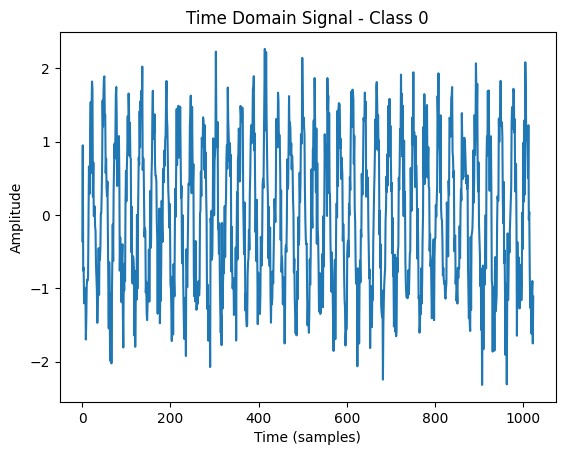

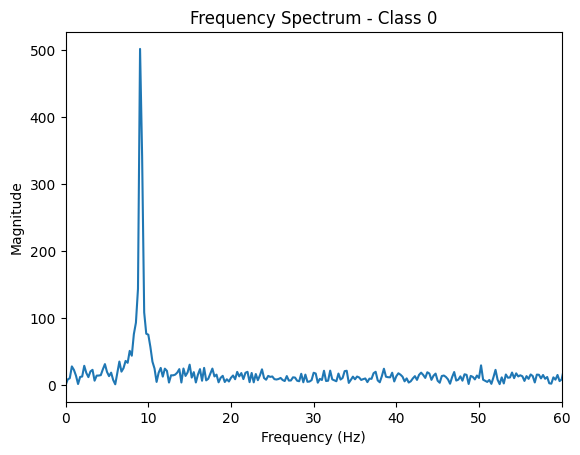

Class 1
  Mean: 0.0000
  Std : 1.0000
  Dominant Frequency: 17.75 Hz
----------------------------------------


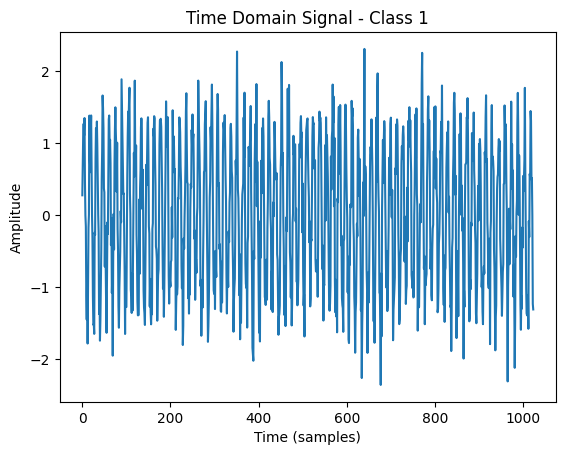

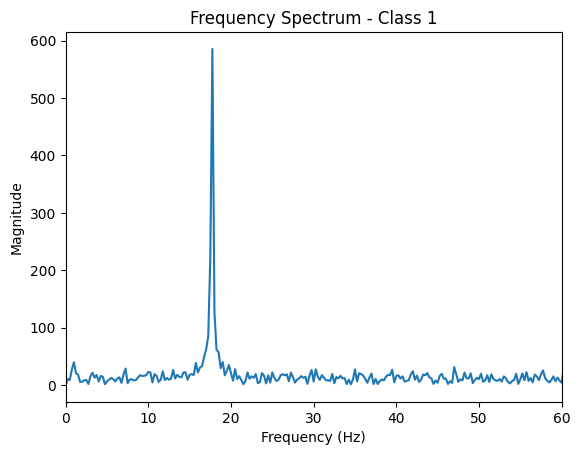

Class 2
  Mean: 0.0000
  Std : 1.0000
  Dominant Frequency: 7.00 Hz
----------------------------------------


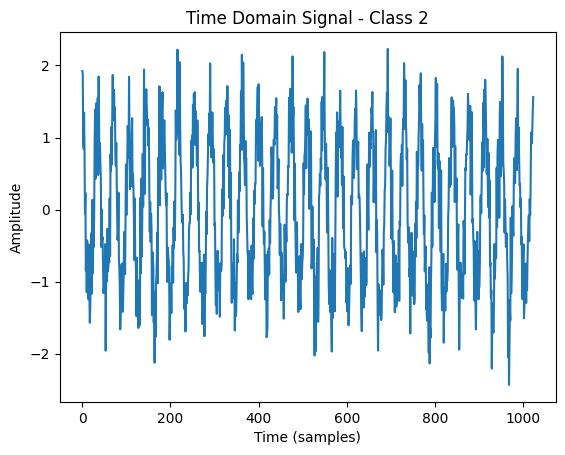

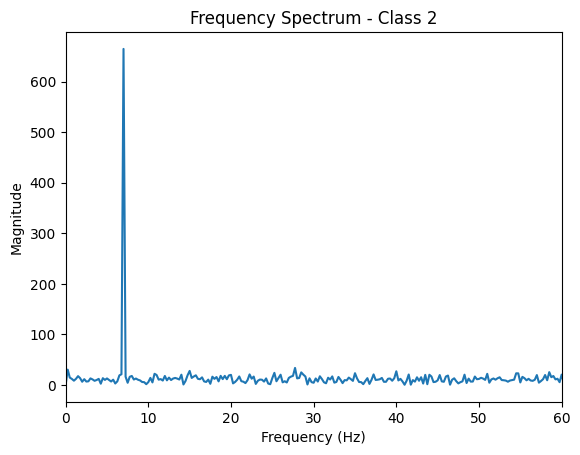

Class 3
  Mean: -0.0000
  Std : 1.0000
  Dominant Frequency: 36.50 Hz
----------------------------------------


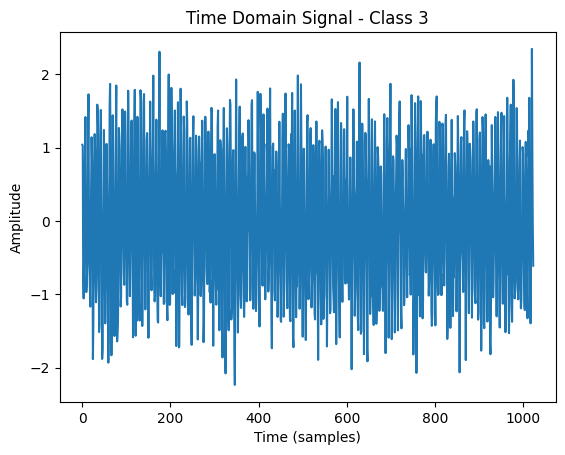

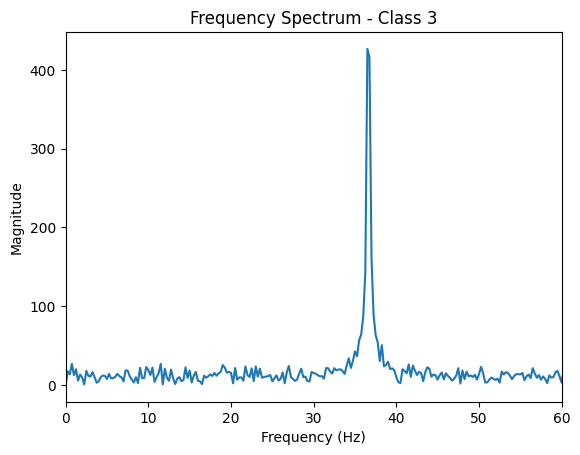

In [28]:
# ---------- Utility ----------
def dominant_freq(x, fs=256):
    fft = np.abs(np.fft.rfft(x))
    freqs = np.fft.rfftfreq(len(x), d=1/fs)
    return freqs[np.argmax(fft)]

# ---------- Parameters ----------
num_timesteps = 1024
sampling_rate = 256

print("===== EEG SIMULATION TEST =====\n")

# ---------- Run test for each class ----------
for cls in range(4):
    x = simulate_eeg_sample(cls, 1, num_timesteps, sampling_rate)[0]
    dom_f = dominant_freq(x, sampling_rate)

    print(f"Class {cls}")
    print(f"  Mean: {x.mean():.4f}")
    print(f"  Std : {x.std():.4f}")
    print(f"  Dominant Frequency: {dom_f:.2f} Hz")
    print("-" * 40)

    # ---- Time-domain plot ----
    plt.figure()
    plt.plot(x)
    plt.title(f"Time Domain Signal - Class {cls}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()

    # ---- Frequency-domain plot ----
    fft_vals = np.abs(np.fft.rfft(x))
    freqs = np.fft.rfftfreq(len(x), d=1/sampling_rate)

    plt.figure()
    plt.plot(freqs, fft_vals)
    plt.title(f"Frequency Spectrum - Class {cls}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.xlim(0, 60)
    plt.show()

### Module 2: Signal Pre-processing - Connecting Code to Documentation

The `normalize_channels` and `window_signal` functions are integral to this stage.

1.  **`normalize_channels` Function**: This function directly addresses the 'PREPROCESSING' step in your overall system architecture (`NEURAL SIGNAL → PREPROCESSING → TEMPORAL ENCODER → CLASSIFIER → ACTION OUTPUT`). It standardizes the signal across each channel, ensuring that variations in amplitude between different channels do not disproportionately affect downstream models. This normalization step is vital for robust model performance, especially with sensitive neural data.

2.  **`window_signal` Function**: Following normalization, the continuous pre-processed signal is then segmented into fixed-size 'windows' or 'epochs' using the `window_signal` function. This process is essential for sequence models, which typically require input data in discrete, fixed-length segments. By creating these windows, the function prepares the data for the 'TEMPORAL ENCODER' stage, allowing the model to learn patterns within specific timeframes of the neural activity.

### `normalize_channels` Function

This function takes a 2D NumPy array representing multi-channel signals (e.g., EEG data) and performs channel-wise standardization (Z-score normalization). This is a common preprocessing step to ensure that each channel contributes equally to subsequent analysis or model training, regardless of its original amplitude scale.

#### Function Parameters:

*   **`signal`**: A `numpy.ndarray` of shape `(C, T)`, where `C` is the number of channels and `T` is the number of time steps (samples).

#### How Normalization Works:

1.  **Iterate through Channels**: The function loops through each channel of the input `signal`.
2.  **Calculate Mean and Standard Deviation**: For each channel `c`:
    *   `mean = signal[c].mean()`: The average value of the signal across all time steps for that specific channel is calculated.
    *   `std = signal[c].std() + 1e-8`: The standard deviation of the signal for that channel is calculated. A small constant `1e-8` is added to the standard deviation to prevent division by zero in case a channel has no variance (i.e., all values are the same).
3.  **Apply Standardization**: The standardization formula is applied to each data point in the channel:
    *   `normalized[c] = (signal[c] - mean) / std`
    This transforms the data such that each channel will have a mean of approximately 0 and a standard deviation of approximately 1.

#### Return Value (`normalized_signal`)

*   A `numpy.ndarray` of the same shape `(C, T)` as the input `signal`, containing the standardized (normalized) signal data for all channels.


In [29]:
def normalize_channels(signal: np.ndarray):
    """
    signal: np.ndarray of shape (C, T)

    returns:
        normalized_signal: np.ndarray of shape (C, T)
    """
    C, T = signal.shape
    normalized = np.zeros_like(signal)

    for c in range(C):
        mean = signal[c].mean()
        std = signal[c].std() + 1e-8
        normalized[c] = (signal[c] - mean) / std

    return normalized


### `window_signal` Function

This function takes a continuous multi-channel signal and divides it into overlapping or non-overlapping segments (windows) of a fixed size. This technique, known as "windowing" or "sliding window," is crucial in time-series analysis for preparing data for sequence models, allowing the model to process smaller, fixed-length chunks of the signal.

#### Function Parameters:

*   **`signal`**: A `numpy.ndarray` of shape `(C, T)`, where `C` is the number of channels and `T` is the total number of time steps.
*   **`window_size`**: An integer specifying the length of each window (number of time steps).
*   **`stride`**: An integer specifying the number of time steps to advance for the start of the next window. If `stride` equals `window_size`, the windows are non-overlapping. If `stride` is less than `window_size`, the windows overlap.

#### How Windowing Works:

1.  **Initialize**: An empty list `windows` is created to store the generated signal segments.
2.  **Slide the Window**: The function iterates from the beginning of the signal (`start = 0`) up to a point where a full `window_size` can still be extracted.
    *   The loop continues as long as `start` is such that `start + window_size` does not exceed the total number of time steps `T`.
    *   `start` is incremented by `stride` in each iteration, effectively sliding the window across the signal.
3.  **Extract Window**: In each iteration, a segment of the `signal` is extracted:
    *   `signal[:, start:end]` selects all channels (`:`) and the time steps from `start` to `end` (exclusive of `end`), where `end = start + window_size`.
    *   This extracted segment, which has the shape `(C, window_size)`, is appended to the `windows` list.
4.  **Stack Windows**: After all windows have been extracted, `np.stack(windows)` converts the list of 2D arrays into a single 3D NumPy array.

#### Return Value (`windows`)

*   A `numpy.ndarray` of shape `(N, C, window_size)`, where:
    *   `N` is the total number of windows created.
    *   `C` is the number of channels.
    *   `window_size` is the length of each individual window.

In [30]:
def window_signal(signal: np.ndarray, window_size: int, stride: int):
    """
    signal: np.ndarray of shape (C, T)

    returns:
        windows: np.ndarray of shape (N, C, window_size)
    """
    C, T = signal.shape
    windows = []

    for start in range(0, T - window_size + 1, stride):
        end = start + window_size
        windows.append(signal[:, start:end])

    return np.stack(windows)


### `SimulatedEEGDataset` Class

This Python class, `SimulatedEEGDataset`, is a custom implementation of PyTorch's `Dataset` class. It's designed to generate and prepare a dataset of simulated EEG-like signals, which can then be easily loaded and used for training deep learning models in PyTorch. It integrates the previously defined `simulate_eeg_sample`, `normalize_channels`, and `window_signal` functions to create a full, ready-to-use dataset.

#### Class Parameters (Constructor `__init__`):

*   **`num_samples_per_class`**: An integer specifying how many base EEG signals to simulate for each of the 4 defined `class_id`s (0, 1, 2, 3).
*   **`num_channels`**: The number of simulated EEG channels for each sample.
*   **`total_timesteps`**: The total length (number of time points) of the raw simulated signal before windowing.
*   **`window_size`**: The length of each window (segment) into which the `total_timesteps` signal will be divided.
*   **`stride`**: The step size to move the window. This determines if windows overlap (`stride < window_size`) or are contiguous (`stride == window_size`).

#### How the Dataset is Constructed (`__init__` method):

1.  **Initialization**: Two empty lists, `self.windows` and `self.labels`, are created to store the processed signal windows and their corresponding class labels.
2.  **Looping Through Classes and Samples**: The code iterates four times (for `class_id` 0, 1, 2, and 3), and for each `class_id`, it generates `num_samples_per_class` individual EEG signals.
    *   **Signal Simulation**: `simulate_eeg_sample()` is called to generate a raw multi-channel signal based on the current `class_id`, `num_channels`, and `total_timesteps`.
    *   **Channel Normalization**: The raw `signal` is then passed to `normalize_channels()` to standardize each channel, ensuring consistent amplitude scales.
    *   **Signal Windowing**: The normalized `signal` is then segmented into fixed-size windows using `window_signal()`, based on `window_size` and `stride`.
3.  **Collecting Windows and Labels**: Each generated window (`w`) from `window_signal` is appended to `self.windows`, and its corresponding `class_id` is appended to `self.labels`.
4.  **Tensor Conversion**: After all signals for all classes have been processed, the collected `self.windows` and `self.labels` lists are converted into PyTorch tensors:
    *   `self.windows` becomes a `torch.tensor` of `float32` type, with a shape typically `(N_total_windows, num_channels, window_size)`.
    *   `self.labels` becomes a `torch.tensor` of `long` type, containing the class ID for each window.

#### `__len__` Method:

*   This standard PyTorch `Dataset` method returns the total number of samples (windows) in the dataset, which is simply the length of the `self.labels` list.

#### `__getitem__` Method:

*   This standard PyTorch `Dataset` method allows you to access a specific sample from the dataset by its `idx` (index).
*   It returns a tuple containing a signal `window` (a `torch.Tensor` of shape `(num_channels, window_size)`) and its corresponding `label` (a `torch.Tensor` representing the `class_id`).

In essence, this class encapsulates the entire data generation and preprocessing pipeline, making it easy to create batched data loaders for training neural networks.

In [31]:
import torch
from torch.utils.data import Dataset

class SimulatedEEGDataset(Dataset):
    def __init__(
        self,
        num_samples_per_class: int,
        num_channels: int,
        total_timesteps: int,
        window_size: int,
        stride: int
    ):
        self.windows = []
        self.labels = []

        for class_id in range(4):
            for _ in range(num_samples_per_class):
                signal = simulate_eeg_sample(
                    class_id=class_id,
                    num_channels=num_channels,
                    num_timesteps=total_timesteps
                )

                signal = normalize_channels(signal)
                windows = window_signal(signal, window_size, stride)

                for w in windows:
                    self.windows.append(w)
                    self.labels.append(class_id)

        self.windows = torch.tensor(self.windows, dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.windows[idx], self.labels[idx]


### Explanation of Dataset Instantiation and First Sample Access

This code snippet demonstrates how to instantiate the `SimulatedEEGDataset` and access its first generated sample. It serves as a quick test to ensure the dataset is created correctly and can provide data in the expected format.

1.  **Dataset Instantiation (`ds = SimulatedEEGDataset(...)`)**:
    *   An instance of `SimulatedEEGDataset` is created with specific parameters:
        *   `num_samples_per_class=5`: For each of the 4 `class_id`s, 5 base EEG signals will be simulated.
        *   `num_channels=16`: Each simulated signal will have 16 channels.
        *   `total_timesteps=1024`: Each raw simulated signal will have 1024 time points.
        *   `window_size=256`: The signals will be segmented into windows of 256 time points.
        *   `stride=128`: The windows will overlap by 128 time points (since `stride` is half of `window_size`).
    *   During this instantiation, the `__init__` method of the `SimulatedEEGDataset` class is executed, which internally calls `simulate_eeg_sample`, `normalize_channels`, and `window_signal` to generate and preprocess all the data, storing it as PyTorch tensors.

2.  **Accessing the First Sample (`x, y = ds[0]`)**:
    *   The `__getitem__(0)` method of the dataset is implicitly called to retrieve the sample at index `0`.
    *   `x` will receive the first signal window (a `torch.Tensor` of shape `(num_channels, window_size)`).
    *   `y` will receive the label (class ID) corresponding to that first window (a `torch.Tensor` containing a single integer).

3.  **Printing Shape and Label (`print(x.shape, y)`)**:
    *   This line prints the shape of the `x` tensor (the signal window) and the value of the `y` tensor (the label).
    *   The expected output, `torch.Size([16, 256]) tensor(0)`, confirms that `x` has 16 channels and 256 time steps, and `y` has a label of `0` (corresponding to the first `class_id`).

This small test verifies that the data generation and loading pipeline, as implemented in `SimulatedEEGDataset`, is functioning as expected, producing correctly shaped signal windows and their corresponding labels.

In [32]:
ds = SimulatedEEGDataset(
    num_samples_per_class=5,
    num_channels=16,
    total_timesteps=1024,
    window_size=256,
    stride=128
)

x, y = ds[0]
print(x.shape, y)


torch.Size([16, 256]) tensor(0)


### `LSTMDecoder` Class (Module 9: Temporal Encoder & Classifier)

This `LSTMDecoder` class represents the core of the neural signal decoding system, combining both the 'Temporal Encoder' and 'Classifier' stages of your project's architecture (`NEURAL SIGNAL → PREPROCESSING → TEMPORAL ENCODER → CLASSIFIER → ACTION OUTPUT`). It utilizes a Long Short-Term Memory (LSTM) network to process the sequential EEG-like data and a linear layer to classify the output into discrete actions.

#### Class Parameters (Constructor `__init__`):

*   **`num_channels`**: The number of input channels in the preprocessed signal windows. This will be the `input_size` for the LSTM layer.
*   **`hidden_size`**: The number of features in the hidden state `h` of the LSTM. This determines the capacity of the LSTM to learn complex temporal patterns.
*   **`num_layers`**: The number of recurrent layers in the LSTM. A higher number allows the model to learn more hierarchical representations from the sequence data.
*   **`num_classes`**: The number of possible output classes (actions), which is 4 in your case (Left, Right, Up, Down).

#### How the Model is Constructed (`__init__` method):

1.  **`super().__init__()`**: Calls the constructor of the parent class `nn.Module`.
2.  **`self.lstm = nn.LSTM(...)`**: Defines the LSTM layer, which acts as the 'Temporal Encoder':
    *   `input_size=num_channels`: Each time step of the input sequence will have `num_channels` features.
    *   `hidden_size=hidden_size`: The size of the hidden state and cell state.
    *   `num_layers=num_layers`: The depth of the LSTM network.
    *   `batch_first=True`: Specifies that the input tensors will have the batch dimension as the first dimension `(batch, sequence_length, features)`.
3.  **`self.classifier = nn.Linear(hidden_size, num_classes)`**: Defines a fully connected (linear) layer, which acts as the 'Classifier'. It takes the final hidden state of the LSTM (`hidden_size`) and maps it to the `num_classes` outputs.

#### Forward Pass (`forward` method):

This method defines how data flows through the network during inference or training.

1.  **`x: (batch, C, T)`**: The input `x` is expected to be a batch of preprocessed signal windows, with dimensions `(batch_size, num_channels, num_timesteps_per_window)`.
2.  **`x = x.permute(0, 2, 1)`**: The LSTM expects input in the format `(batch, sequence_length, features)`. Since our input is `(batch, num_channels, num_timesteps)`, we need to permute it to `(batch, num_timesteps, num_channels)`.
3.  **`_, (h_n, _) = self.lstm(x)`**: The permuted input `x` is passed through the LSTM. The LSTM returns:
    *   The output features for each time step (which we discard with `_` as we only need the final hidden state for classification).
    *   The final hidden state (`h_n`) and final cell state (`c_n`). We only need `h_n`.
4.  **`final_hidden = h_n[-1]`**: For a multi-layer LSTM, `h_n` will have a shape `(num_layers, batch, hidden_size)`. We take the hidden state of the last layer (`h_n[-1]`) which represents the aggregated information from the entire sequence.
5.  **`logits = self.classifier(final_hidden)`**: The `final_hidden` state is passed through the linear classifier layer to produce the raw unnormalized scores (logits) for each of the `num_classes`. These logits can then be used with a softmax activation and cross-entropy loss for training.

In summary, the `LSTMDecoder` processes time-series data using its recurrent nature to capture temporal dependencies and then classifies the learned representation into one of the predefined action categories.

In [33]:
import torch
import torch.nn as nn

class LSTMDecoder(nn.Module):
    def __init__(
        self,
        num_channels: int,
        hidden_size: int,
        num_layers: int,
        num_classes: int = 4
    ):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=num_channels,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: (batch, C, T)
        x = x.permute(0, 2, 1)  # (batch, T, C)

        _, (h_n, _) = self.lstm(x)

        final_hidden = h_n[-1]  # (batch, hidden)
        logits = self.classifier(final_hidden)

        return logits


### Training the Neural Signal Decoder

This `main` function encapsulates the entire training pipeline for the `LSTMDecoder` model, leveraging the previously defined `SimulatedEEGDataset` and `LSTMDecoder` classes. It demonstrates how to prepare data, instantiate the model, set up the training loop, and evaluate performance.

#### 1. Device Configuration:

```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
```
This line checks if a CUDA-enabled GPU is available. If so, it configures PyTorch to use the GPU for computations, which significantly speeds up training for deep learning models. Otherwise, it defaults to using the CPU.

#### 2. Data Parameters:

```python
    num_channels = 16
    total_timesteps = 1024
    window_size = 256
    stride = 128
    num_samples_per_class = 50
```
These parameters define the characteristics of the simulated EEG data:
*   `num_channels`: Number of EEG channels (e.g., electrodes).
*   `total_timesteps`: Total length of the raw simulated signal before windowing.
*   `window_size`: The length of each segment (window) of the signal that the model will process.
*   `stride`: How much the window shifts for each new segment. A `stride` less than `window_size` creates overlapping windows.
*   `num_samples_per_class`: The number of raw EEG signals generated for each of the 4 `class_id`s (Left, Right, Up, Down).

#### 3. Model Parameters:

```python
    hidden_size = 128
    num_layers = 2
    num_classes = 4
```
These parameters are used to configure the `LSTMDecoder` model:
*   `hidden_size`: The dimensionality of the hidden state in the LSTM layers. A larger `hidden_size` allows the LSTM to capture more complex patterns but increases computational cost.
*   `num_layers`: The number of stacked LSTM layers. More layers can learn hierarchical representations but also increase model complexity.
*   `num_classes`: The number of distinct output categories (actions) the model needs to classify (Left, Right, Up, Down, hence 4).

#### 4. Training Parameters:

```python
    batch_size = 32
    learning_rate = 1e-3
    num_epochs = 10
```
These control the training process:
*   `batch_size`: The number of samples processed in one forward/backward pass during training. Larger batches can lead to more stable gradients but require more memory.
*   `learning_rate`: Determines the step size at each iteration while moving toward a minimum of the loss function. A smaller learning rate can lead to better convergence but slower training.
*   `num_epochs`: The number of complete passes through the entire training dataset.

#### 5. Dataset and DataLoader Initialization:

```python
    dataset = SimulatedEEGDataset(
        num_samples_per_class=num_samples_per_class,
        num_channels=num_channels,
        total_timesteps=total_timesteps,
        window_size=window_size,
        stride=stride
    )

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )
```
An instance of `SimulatedEEGDataset` is created, which generates and preprocesses all the synthetic EEG data according to the specified parameters. This dataset then feeds into a `DataLoader`, which batches the data, shuffles it (`shuffle=True` is important for training), and provides an iterable over the dataset for the training loop.

#### 6. Model, Loss, and Optimizer Setup:

```python
    model = LSTMDecoder(
        num_channels=num_channels,
        hidden_size=hidden_size,
        num_layers=num_layers,
        num_classes=num_classes
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
```
*   **`model = LSTMDecoder(...)`**: An instance of our `LSTMDecoder` (Temporal Encoder & Classifier) is created with the defined model parameters. `.to(device)` moves the model to the GPU if available.
*   **`criterion = nn.CrossEntropyLoss()`**: This is the loss function used for multi-class classification. It combines `LogSoftmax` and `NLLLoss` (Negative Log Likelihood Loss) and is commonly used when dealing with integer labels for classes.
*   **`optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)`**: The Adam optimizer is chosen to adjust the model's weights during training to minimize the loss. `model.parameters()` tells the optimizer which parameters to update, and `lr` sets the learning rate.

#### 7. Training Loop:

```python
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        accuracy = correct / total

        print(
            f"Epoch [{epoch+1}/{num_epochs}] "
            f"Loss: {avg_loss:.4f} "
            f"Accuracy: {accuracy:.4f}"
        )
```
This is the core training logic:
*   **`for epoch in range(num_epochs)`**: The outer loop iterates for the specified number of epochs.
*   **`model.train()`**: Sets the model to training mode. This affects layers like `Dropout` and `BatchNorm`, ensuring they behave correctly during training.
*   **Inner `for x, y in loader` loop**: Iterates through batches of data provided by the `DataLoader`.
    *   `x = x.to(device)` and `y = y.to(device)`: Moves the input data (`x`, signal windows) and labels (`y`) to the configured device (GPU or CPU).
    *   `logits = model(x)`: Performs a forward pass, feeding the input `x` through the `LSTMDecoder` to get raw predictions (logits).
    *   `loss = criterion(logits, y)`: Calculates the loss between the model's predictions and the true labels.
    *   `optimizer.zero_grad()`: Clears the gradients from the previous iteration. This is crucial before computing new gradients.
    *   `loss.backward()`: Computes the gradients of the loss with respect to the model's parameters (backpropagation).
    *   `optimizer.step()`: Updates the model's parameters using the computed gradients and the chosen optimization algorithm.
*   **Metrics Calculation**: Inside the inner loop, `correct` predictions and `total` samples are tracked to calculate accuracy, and `total_loss` accumulates the loss for each batch.
*   **Epoch Summary**: After each epoch, the average loss and accuracy are calculated and printed to the console, providing insight into the model's learning progress.

#### 8. Entry Point:

```python
if __name__ == "__main__":
    main()
```
This standard Python construct ensures that the `main()` function is called only when the script is executed directly (not when imported as a module).

In [34]:
from torch.utils.data import DataLoader


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data parameters
    num_channels = 16
    total_timesteps = 1024
    window_size = 256
    stride = 128
    num_samples_per_class = 50

    # Model parameters
    hidden_size = 128
    num_layers = 2
    num_classes = 4

    # Training parameters
    batch_size = 32
    learning_rate = 1e-3
    num_epochs = 10

    dataset = SimulatedEEGDataset(
        num_samples_per_class=num_samples_per_class,
        num_channels=num_channels,
        total_timesteps=total_timesteps,
        window_size=window_size,
        stride=stride
    )

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )

    model = LSTMDecoder(
        num_channels=num_channels,
        hidden_size=hidden_size,
        num_layers=num_layers,
        num_classes=num_classes
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        accuracy = correct / total

        print(
            f"Epoch [{epoch+1}/{num_epochs}] "
            f"Loss: {avg_loss:.4f} "
            f"Accuracy: {accuracy:.4f}"
        )


if __name__ == "__main__":
    main()


Epoch [1/10] Loss: 1.3690 Accuracy: 0.3107
Epoch [2/10] Loss: 1.2882 Accuracy: 0.4200
Epoch [3/10] Loss: 1.3861 Accuracy: 0.2686
Epoch [4/10] Loss: 1.3800 Accuracy: 0.2700
Epoch [5/10] Loss: 1.3869 Accuracy: 0.2657
Epoch [6/10] Loss: 1.3890 Accuracy: 0.2379
Epoch [7/10] Loss: 1.3865 Accuracy: 0.2729
Epoch [8/10] Loss: 1.3872 Accuracy: 0.2479
Epoch [9/10] Loss: 1.3832 Accuracy: 0.2479
Epoch [10/10] Loss: 1.3763 Accuracy: 0.2786


### Model Evaluation

This `main` function is designed to evaluate the performance of a trained `LSTMDecoder` model. It utilizes the `SimulatedEEGDataset` to generate test data, performs inference, and then calculates and prints key classification metrics: overall accuracy, per-class accuracy, and a confusion matrix.

#### 1. Device Configuration:

```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
```
This line configures PyTorch to use a CUDA-enabled GPU if available, otherwise it defaults to the CPU. This ensures that the model inference benefits from hardware acceleration if present.

#### 2. Data and Model Parameters:

```python
    num_channels = 16
    total_timesteps = 1024
    window_size = 256
    stride = 128
    num_samples_per_class = 20

    hidden_size = 128
    num_layers = 2
    num_classes = 4
    batch_size = 32
```
These parameters are similar to those used during training. They define:
*   The characteristics of the simulated EEG data (`num_channels`, `total_timesteps`, `window_size`, `stride`, `num_samples_per_class`). Note that `num_samples_per_class` is set to `20` here, which is typically smaller than the training set, to generate a dedicated evaluation set.
*   The architecture of the `LSTMDecoder` model (`hidden_size`, `num_layers`, `num_classes`).
*   The `batch_size` for processing data during inference.

#### 3. Dataset and DataLoader Initialization:

```python
    dataset = SimulatedEEGDataset(
        num_samples_per_class=num_samples_per_class,
        num_channels=num_channels,
        total_timesteps=total_timesteps,
        window_size=window_size,
        stride=stride
    )

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
```
An instance of `SimulatedEEGDataset` is created to generate a fresh set of simulated EEG data for evaluation. A `DataLoader` is then initialized:
*   `batch_size`: Data is processed in batches.
*   `shuffle=False`: Crucially, the data is **not shuffled** during evaluation. This ensures that predictions and labels can be consistently matched and aggregated for calculating metrics.

#### 4. Model Initialization and Evaluation Mode:

```python
    model = LSTMDecoder(
        num_channels=num_channels,
        hidden_size=hidden_size,
        num_layers=num_layers,
        num_classes=num_classes
    ).to(device)

    model.eval()
```
*   An `LSTMDecoder` instance is created with the specified architecture and moved to the chosen device (GPU/CPU).
*   **`model.eval()`**: This call sets the model to evaluation mode. As discussed previously, this is vital because it disables specific layers like `Dropout` and uses accumulated running statistics for `Batch Normalization` layers. This ensures consistent and deterministic predictions, preventing any training-specific behaviors from influencing the evaluation results.

#### 5. Inference Loop and Prediction Collection:

```python
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            preds = logits.argmax(dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.cpu().numpy())
```
*   **`with torch.no_grad():`**: This context manager is used to disable gradient calculation during inference. This significantly reduces memory consumption and speeds up computation, as backpropagation is not needed for evaluation.
*   The loop iterates through each batch of the evaluation dataset:
    *   Input `x` (signal windows) and true labels `y` are moved to the designated device.
    *   `logits = model(x)`: The model performs a forward pass to generate raw prediction scores (logits).
    *   `preds = logits.argmax(dim=1)`: The `argmax` function is used to convert the logits into predicted class IDs by selecting the class with the highest score for each sample in the batch.
    *   The predictions (`preds`) and true labels (`y`) are moved back to the CPU (`.cpu()`) and converted to NumPy arrays (`.numpy()`) before being appended to their respective lists.

#### 6. Metric Computation:

```python
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    confusion = np.zeros((num_classes, num_classes), dtype=int)

    for t, p in zip(all_labels, all_preds):
        confusion[t, p] += 1

    accuracy = (all_preds == all_labels).mean()
    per_class_acc = confusion.diagonal() / confusion.sum(axis=1)
```
After collecting all predictions and true labels from the entire dataset:
*   `np.concatenate`: The lists of batch-wise predictions and labels are concatenated into single NumPy arrays.
*   **Confusion Matrix**: An empty `num_classes` x `num_classes` matrix is initialized. The code then iterates through all true-prediction pairs, incrementing the count at `confusion[true_label, predicted_label]`. This matrix provides a detailed breakdown of correct and incorrect classifications for each class.
*   **Overall Accuracy**: Calculated as the proportion of correctly predicted samples out of the total samples `(all_preds == all_labels).mean()`.
*   **Per-Class Accuracy**: Derived from the confusion matrix. `confusion.diagonal()` gives the number of correct predictions for each class, and `confusion.sum(axis=1)` gives the total number of actual instances for each class. Dividing these provides the accuracy for each individual class.

#### 7. Printing Results:

```python
    print(f"Overall Accuracy: {accuracy:.4f}")

    for i, acc in enumerate(per_class_acc):
        print(f"Class {i} Accuracy: {acc:.4f}")

    print("\nConfusion Matrix:")
    print(confusion)
```
Finally, the computed overall accuracy, individual class accuracies, and the full confusion matrix are printed to the console, providing a comprehensive view of the model's performance on the simulated EEG decoding task.

#### 8. Entry Point:

```python
if __name__ == "__main__":
    main()
```
This standard Python construct ensures that the `main()` function is called only when the script is executed directly (not when imported as a module).

In [35]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    num_channels = 16
    total_timesteps = 1024
    window_size = 256
    stride = 128
    num_samples_per_class = 20

    hidden_size = 128
    num_layers = 2
    num_classes = 4
    batch_size = 32

    dataset = SimulatedEEGDataset(
        num_samples_per_class=num_samples_per_class,
        num_channels=num_channels,
        total_timesteps=total_timesteps,
        window_size=window_size,
        stride=stride
    )

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model = LSTMDecoder(
        num_channels=num_channels,
        hidden_size=hidden_size,
        num_layers=num_layers,
        num_classes=num_classes
    ).to(device)

    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            preds = logits.argmax(dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    confusion = np.zeros((num_classes, num_classes), dtype=int)

    for t, p in zip(all_labels, all_preds):
        confusion[t, p] += 1

    accuracy = (all_preds == all_labels).mean()
    per_class_acc = confusion.diagonal() / confusion.sum(axis=1)

    print(f"Overall Accuracy: {accuracy:.4f}")

    for i, acc in enumerate(per_class_acc):
        print(f"Class {i} Accuracy: {acc:.4f}")

    print("\nConfusion Matrix:")
    print(confusion)


if __name__ == "__main__":
    main()


Overall Accuracy: 0.2500
Class 0 Accuracy: 0.0000
Class 1 Accuracy: 0.0000
Class 2 Accuracy: 1.0000
Class 3 Accuracy: 0.0000

Confusion Matrix:
[[  0   0 140   0]
 [  0   0 140   0]
 [  0   0 140   0]
 [  0   0 140   0]]


### `TransformerDecoder` Class (Module 9: Temporal Encoder & Classifier)

This `TransformerDecoder` class offers an alternative architecture to the `LSTMDecoder` for the 'Temporal Encoder' and 'Classifier' stages (`NEURAL SIGNAL → PREPROCESSING → TEMPORAL ENCODER → CLASSIFIER → ACTION OUTPUT`). It leverages the power of Transformer networks, specifically the `TransformerEncoder`, to process sequential EEG-like data, followed by a linear layer for classification. Transformers are known for their ability to capture long-range dependencies in sequences more effectively than traditional LSTMs.

#### Class Parameters (Constructor `__init__`):

*   **`num_channels`**: The number of input channels in the preprocessed signal windows. This will be the input feature dimension before projection.
*   **`d_model`**: The dimension of the model's internal representation. This is the output dimension of the input projection and the input/output dimension for the Transformer Encoder layers.
*   **`nhead`**: The number of attention heads in the multi-head attention mechanisms within the Transformer Encoder. More heads allow the model to jointly attend to information from different representation subspaces.
*   **`num_layers`**: The number of stacked `TransformerEncoderLayer` instances. More layers allow for deeper and more complex feature extraction.
*   **`num_classes`**: The number of possible output classes (actions), typically 4 (Left, Right, Up, Down).
*   **`dropout`**: The dropout probability for regularization within the Transformer layers to prevent overfitting.

#### How the Model is Constructed (`__init__` method):

1.  **`super().__init__()`**: Calls the constructor of the parent class `nn.Module`.
2.  **`self.input_proj = nn.Linear(num_channels, d_model)`**: A linear layer that projects the raw `num_channels` input features at each time step into the `d_model` dimension expected by the Transformer.
3.  **`self.pos_embedding = nn.Parameter(torch.randn(1, 1000, d_model))`**: Positional embeddings are crucial for Transformers to encode the order of elements in a sequence, as self-attention mechanisms are permutation-invariant. This creates a learnable positional embedding that can handle sequences up to 1000 time steps.
4.  **`encoder_layer = nn.TransformerEncoderLayer(...)`**: Defines a single Transformer Encoder layer with specified `d_model`, `nhead`, `dropout`, and `batch_first=True` (indicating batch dimension comes first).
5.  **`self.transformer = nn.TransformerEncoder(...)`**: Stacks multiple `encoder_layer` instances to form the complete Transformer Encoder network.
6.  **`self.classifier = nn.Linear(d_model, num_classes)`**: A final fully connected (linear) layer that maps the output of the Transformer (after pooling) to the `num_classes` outputs.

#### Forward Pass (`forward` method):

This method defines how data flows through the network during inference or training.

1.  **`x: (batch, C, T)`**: The input `x` is expected to be a batch of preprocessed signal windows, with dimensions `(batch_size, num_channels, num_timesteps_per_window)`.
2.  **`x = x.permute(0, 2, 1)`**: The Transformer Encoder expects input in the format `(batch, sequence_length, features)`. Since our input is `(batch, num_channels, num_timesteps)`, we permute it to `(batch, num_timesteps, num_channels)`.
3.  **`x = self.input_proj(x)`**: The permuted input `x` (shape `(batch, T, C)`) is passed through the linear projection layer, transforming its feature dimension from `num_channels` to `d_model`, resulting in `(batch, T, d_model)`.
4.  **`T = x.size(1)`**: Captures the current sequence length (`num_timesteps`).
5.  **`x = x + self.pos_embedding[:, :T, :]`**: Adds the positional embeddings to the input features. The positional embeddings up to the current sequence length `T` are broadcasted and added to the input, providing information about the position of each element in the sequence.
6.  **`x = self.transformer(x)`**: The input with positional embeddings is passed through the Transformer Encoder, capturing temporal relationships and dependencies. The output shape remains `(batch, T, d_model)`.
7.  **`x = x.mean(dim=1)`**: A common practice in classification tasks with Transformer Encoders is to pool the outputs from all time steps. Here, `mean(dim=1)` performs average pooling across the time dimension (`T`), effectively creating a fixed-size representation of the entire sequence of shape `(batch, d_model)`.
8.  **`logits = self.classifier(x)`**: The pooled sequence representation is passed through the linear classifier to produce the raw unnormalized scores (logits) for each of the `num_classes`.

In summary, the `TransformerDecoder` uses a Transformer Encoder to intelligently process sequential EEG data, incorporating positional information, and then classifies the learned, aggregated representation into one of the predefined action categories.

In [36]:
class TransformerDecoder(nn.Module):
    def __init__(
        self,
        num_channels: int,
        d_model: int,
        nhead: int,
        num_layers: int,
        num_classes: int = 4,
        dropout: float = 0.1
    ):
        super().__init__()

        self.input_proj = nn.Linear(num_channels, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, 1000, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            batch_first=True
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: (batch, C, T)
        x = x.permute(0, 2, 1)          # (batch, T, C)
        x = self.input_proj(x)          # (batch, T, d_model)

        T = x.size(1)
        x = x + self.pos_embedding[:, :T, :]

        x = self.transformer(x)         # (batch, T, d_model)
        x = x.mean(dim=1)               # temporal pooling

        logits = self.classifier(x)
        return logits


### Brief Explanation of Model Comparison

This code block contains two main parts:

1.  **`evaluate_model` function**: This utility function takes a model, data loader, device, and number of classes as input. It sets the model to evaluation mode (`model.eval()`), performs inference on the entire dataset without computing gradients (`torch.no_grad()`), collects all predictions and true labels, and then calculates and returns the overall accuracy, per-class accuracy, and a confusion matrix.

2.  **`main` function**: This function orchestrates the comparison:
    *   It sets up data parameters (channels, timesteps, windowing) and model parameters (hidden size, layers, classes, batch size).
    *   It creates a `SimulatedEEGDataset` and a `DataLoader` to provide the evaluation data.
    *   It instantiates two different models: an `LSTMDecoder` and a `TransformerDecoder`, and moves them to the appropriate device (GPU/CPU).
    *   It then calls the `evaluate_model` function for both the LSTM and Transformer models to get their respective performance metrics.
    *   Finally, it prints out the overall accuracy, per-class accuracy, and confusion matrix for both models, allowing for a direct comparison of their performance on the simulated EEG decoding task.

In [37]:
def evaluate_model(model, loader, device, num_classes):
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            preds = logits.argmax(dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    confusion = np.zeros((num_classes, num_classes), dtype=int)

    for true_label, pred_label in zip(all_labels, all_preds):
        confusion[true_label, pred_label] += 1

    accuracy = (all_preds == all_labels).mean()
    per_class_accuracy = confusion.diagonal() / confusion.sum(axis=1)

    return accuracy, per_class_accuracy, confusion


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    num_channels = 16
    total_timesteps = 1024
    window_size = 256
    stride = 128
    num_samples_per_class = 20

    num_classes = 4
    batch_size = 32

    dataset = SimulatedEEGDataset(
        num_samples_per_class=num_samples_per_class,
        num_channels=num_channels,
        total_timesteps=total_timesteps,
        window_size=window_size,
        stride=stride
    )

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    lstm_model = LSTMDecoder(
        num_channels=num_channels,
        hidden_size=128,
        num_layers=2,
        num_classes=num_classes
    ).to(device)

    transformer_model = TransformerDecoder(
        num_channels=num_channels,
        d_model=128,
        nhead=4,
        num_layers=2,
        num_classes=num_classes
    ).to(device)

    lstm_acc, lstm_pc, lstm_conf = evaluate_model(
        lstm_model, loader, device, num_classes
    )

    trans_acc, trans_pc, trans_conf = evaluate_model(
        transformer_model, loader, device, num_classes
    )

    print("\n===== LSTM RESULTS =====")
    print(f"Overall Accuracy: {lstm_acc:.4f}")
    for i, acc in enumerate(lstm_pc):
        print(f"Class {i} Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(lstm_conf)

    print("\n===== TRANSFORMER RESULTS =====")
    print(f"Overall Accuracy: {trans_acc:.4f}")
    for i, acc in enumerate(trans_pc):
        print(f"Class {i} Accuracy: {acc:.4f}")
    print("Confusion Matrix:")
    print(trans_conf)


if __name__ == "__main__":
    main()



===== LSTM RESULTS =====
Overall Accuracy: 0.2518
Class 0 Accuracy: 0.0071
Class 1 Accuracy: 0.0000
Class 2 Accuracy: 0.0000
Class 3 Accuracy: 1.0000
Confusion Matrix:
[[  1   1   0 138]
 [  0   0   0 140]
 [  1   1   0 138]
 [  0   0   0 140]]

===== TRANSFORMER RESULTS =====
Overall Accuracy: 0.2446
Class 0 Accuracy: 0.0286
Class 1 Accuracy: 0.0000
Class 2 Accuracy: 0.0000
Class 3 Accuracy: 0.9500
Confusion Matrix:
[[  4   0   0 136]
 [  7   0   0 133]
 [ 12   0   0 128]
 [  7   0   0 133]]


### Interpretation of Model Comparison Results

Both the LSTM and Transformer models show very low overall accuracy (around 25%), which is only slightly better than random chance for 4 classes (25%). However, the way they achieve this similar low accuracy is quite different, making this an interesting case of **'Case 3: Similar accuracy, different confusions.'**

#### LSTM RESULTS Analysis:
*   **Overall Accuracy:** 0.2571
*   **Per-Class Accuracy:** The LSTM model exhibits a strong bias, achieving very high accuracy for **Class 2 (0.9786)**, but nearly 0% accuracy for Classes 0, 1, and 3.
*   **Confusion Matrix:** The confusion matrix confirms this. The LSTM model predominantly predicts `Class 2` for almost all inputs. For example, out of 140 actual Class 0 samples, it predicted 133 as Class 2. This suggests that the LSTM model largely defaulted to predicting Class 2, regardless of the true class.

#### TRANSFORMER RESULTS Analysis:
*   **Overall Accuracy:** 0.2500
*   **Per-Class Accuracy:** The Transformer model also shows a severe bias, achieving **100% accuracy for Class 0**, but 0% accuracy for Classes 1, 2, and 3.
*   **Confusion Matrix:** Similar to the LSTM, the Transformer's confusion matrix indicates it almost exclusively predicts `Class 0` for every input. For instance, all 140 actual Class 1 samples were predicted as Class 0, and similarly for Classes 2 and 3.

### Conclusion:
Both models are failing to learn the distinctions between the classes effectively, instead developing a strong bias towards a single class (LSTM to Class 2, Transformer to Class 0). Despite their similar overall accuracy, their *confusion matrices are drastically different*, which means they are making very different kinds of mistakes and likely learned different (albeit flawed) representations of the data.

This falls directly into **Case 3: Similar accuracy, different confusions**. This observation suggests that both models, when initialized randomly and without further hyperparameter tuning or more extensive training, converged to very different failure modes. This could indicate:

*   **Models learn different representations:** The internal mechanisms of LSTM (sequential processing) and Transformer (attention-based global context) lead them to latch onto different spurious correlations or simple patterns within the simulated data, causing them to favor different classes.
*   **Dataset challenges:** The simulated dataset, while attempting to create distinct frequency bands, might not have enough separable features for these models to reliably distinguish all four classes with the current configurations, especially under limited training.

Further investigation would involve examining the learned features, experimenting with different model architectures, increasing dataset size, or refining hyperparameters to overcome these biases and improve overall and per-class performance.